## imports

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style("white")

import pandas as pd
import numpy as np
from  neefasa_proj3 import *
import datetime as dt

In [5]:
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [7]:
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn import tree

# Flight Data

I used the flight data from the Bureau of Transportation Statistics website (bts.gov).

In [149]:
flight = pd.read_csv('438043864_T_ONTIME_REPORTING.csv')

In [565]:
flight[(flight.ORIGIN == 'ORD')]['OP_UNIQUE_CARRIER'].value_counts()

UA    5191
MQ    4929
AA    4902
OO    4459
YX    1090
EV    1051
DL     738
NK     665
F9     240
AS     192
B6     190
9E     142
OH     130
Name: OP_UNIQUE_CARRIER, dtype: int64

## Focus on O'hare departures

In [535]:
flightORD = flight[(flight.ORIGIN == 'ORD')]

In [571]:
flightORD.shape

(23919, 76)

In [537]:
flightORD.DEP_DEL15.isna().value_counts()

False    22797
True      1122
Name: DEP_DEL15, dtype: int64

In [538]:
(flightORD.CANCELLED == 1).value_counts()

False    22752
True      1167
Name: CANCELLED, dtype: int64

In [540]:
flightORD.loc[:,'DEP_DEL15'] = flightORD.DEP_DEL15.fillna(0)
flightORD.loc[:,'CANCELLED'] = flightORD.CANCELLED.fillna(0)

In [541]:
flightORD.DEP_DEL15.isna().value_counts()

False    23919
Name: DEP_DEL15, dtype: int64

In [542]:
flightORD.loc[:,'NOT_ON_TIME'] = flightORD.DEP_DEL15 + flightORD.CANCELLED

In [543]:
flightORD.NOT_ON_TIME.value_counts()

0.0    16495
1.0     7401
2.0       23
Name: NOT_ON_TIME, dtype: int64

In [544]:
flightORD.loc[:,'NOT_ON_TIME'] = flightORD.NOT_ON_TIME.replace({2:1})

In [545]:
flightORD.NOT_ON_TIME.value_counts()

0.0    16495
1.0     7424
Name: NOT_ON_TIME, dtype: int64

## Add new features

In [546]:
carrier_rates = pd.read_csv('new_features/carrier_rates.csv')
flnum_rates = pd.read_csv('new_features/flnum_rates.csv')
tailnum_rates = pd.read_csv('new_features/tailnum_rates.csv')

### Delay rates by carrier

In [547]:
carrier_rates['OP_UNIQUE_CARRIER'] = carrier_rates['Airline']

In [549]:
flightORD = flightORD.merge(carrier_rates[['OP_UNIQUE_CARRIER','carrier_total_rate','carrier_cancel_rate','carrier_delay_rate']], how='left', on='OP_UNIQUE_CARRIER')

### Delay rates by flight number

In [551]:
flightORD['Car_flnum'] = flightORD['OP_UNIQUE_CARRIER']+flightORD['OP_CARRIER_FL_NUM'].astype(str)

In [552]:
flightORD = flightORD.merge(flnum_rates[['Car_flnum','flnum_total_rate','flnum_cancel_rate','flnum_delay_rate']], how='left', on='Car_flnum')

### Delay rates by tail number

In [554]:
tailnum_rates['TAIL_NUM'] = tailnum_rates['tail_num']

In [556]:
flightORD = flightORD.merge(tailnum_rates[['TAIL_NUM','tailnum_total_rate','tailnum_cancel_rate','tailnum_delay_rate']], how='left', on='TAIL_NUM')

### Daily Weather

In [557]:
febW = pd.read_csv('new_features/febW.csv')

In [558]:
febW['FL_DATE'] = febW['Unnamed: 0']

In [559]:
febW.loc[:,'precipType'] = febW.precipType.replace({'snow':2,'rain':1, np.nan: 0})

In [561]:
flightORD = flightORD.merge(febW[['FL_DATE','moonPhase','precipProbability','precipAccumulation','precipIntensityMax','precipType','windBearing','windSpeed']], how='left', on='FL_DATE')

In [48]:
flightORD['precipSnow'] = flightORD.precipType.replace({1:0}).replace({2:1})

In [43]:
flightORD = flightORD.fillna(0)

In [49]:
flightORD.to_csv('flightORD.csv')

In [8]:
flightORD = pd.read_csv('flightORD.csv', index_col=0)

# EDA

In [13]:
flightORD['OP_UNIQUE_CARRIER'].value_counts()

UA    5191
MQ    4929
AA    4902
OO    4459
YX    1090
EV    1051
DL     738
NK     665
F9     240
AS     192
B6     190
9E     142
OH     130
Name: OP_UNIQUE_CARRIER, dtype: int64

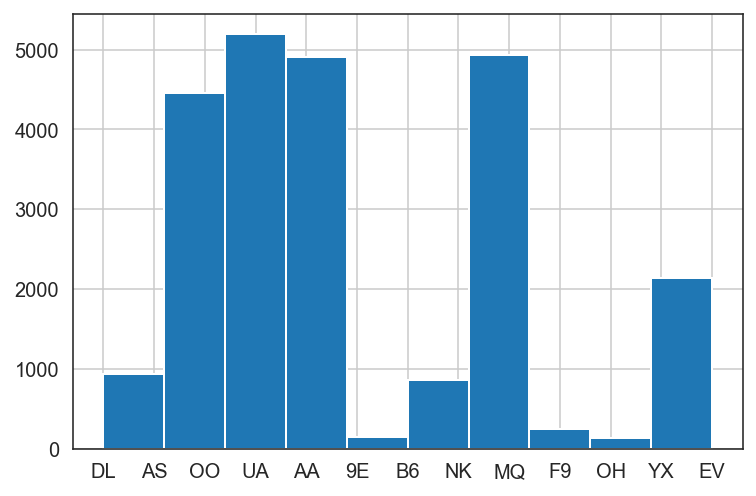

In [12]:
flightORD['OP_UNIQUE_CARRIER'].hist()

In [33]:
flightORD.groupby(['OP_UNIQUE_CARRIER']).sum()['NOT_ON_TIME']

OP_UNIQUE_CARRIER
9E      63.0
AA    1446.0
AS      66.0
B6      85.0
DL     189.0
EV     467.0
F9      66.0
MQ    1712.0
NK     154.0
OH      42.0
OO    1642.0
UA    1244.0
YX     248.0
Name: NOT_ON_TIME, dtype: float64

In [34]:
flightORD.groupby(['DAY_OF_WEEK']).sum()['NOT_ON_TIME']

DAY_OF_WEEK
1    1371.0
2    1113.0
3    1141.0
4     791.0
5    1001.0
6     505.0
7    1502.0
Name: NOT_ON_TIME, dtype: float64

In [35]:
mask = [
    'NOT_ON_TIME',
    'DAY_OF_WEEK', 
    'OP_CARRIER_AIRLINE_ID', 
    'OP_CARRIER_FL_NUM', 
    'DEST_AIRPORT_ID',
    'CRS_DEP_TIME', 
    'CRS_ELAPSED_TIME', 
    'DISTANCE',
    'DISTANCE_GROUP',
    'carrier_total_rate',
    'flnum_total_rate',
    'tailnum_total_rate',
    'moonPhase', 
    'precipProbability',
    'windBearing',
    'windSpeed',
    'precipSnow'
]

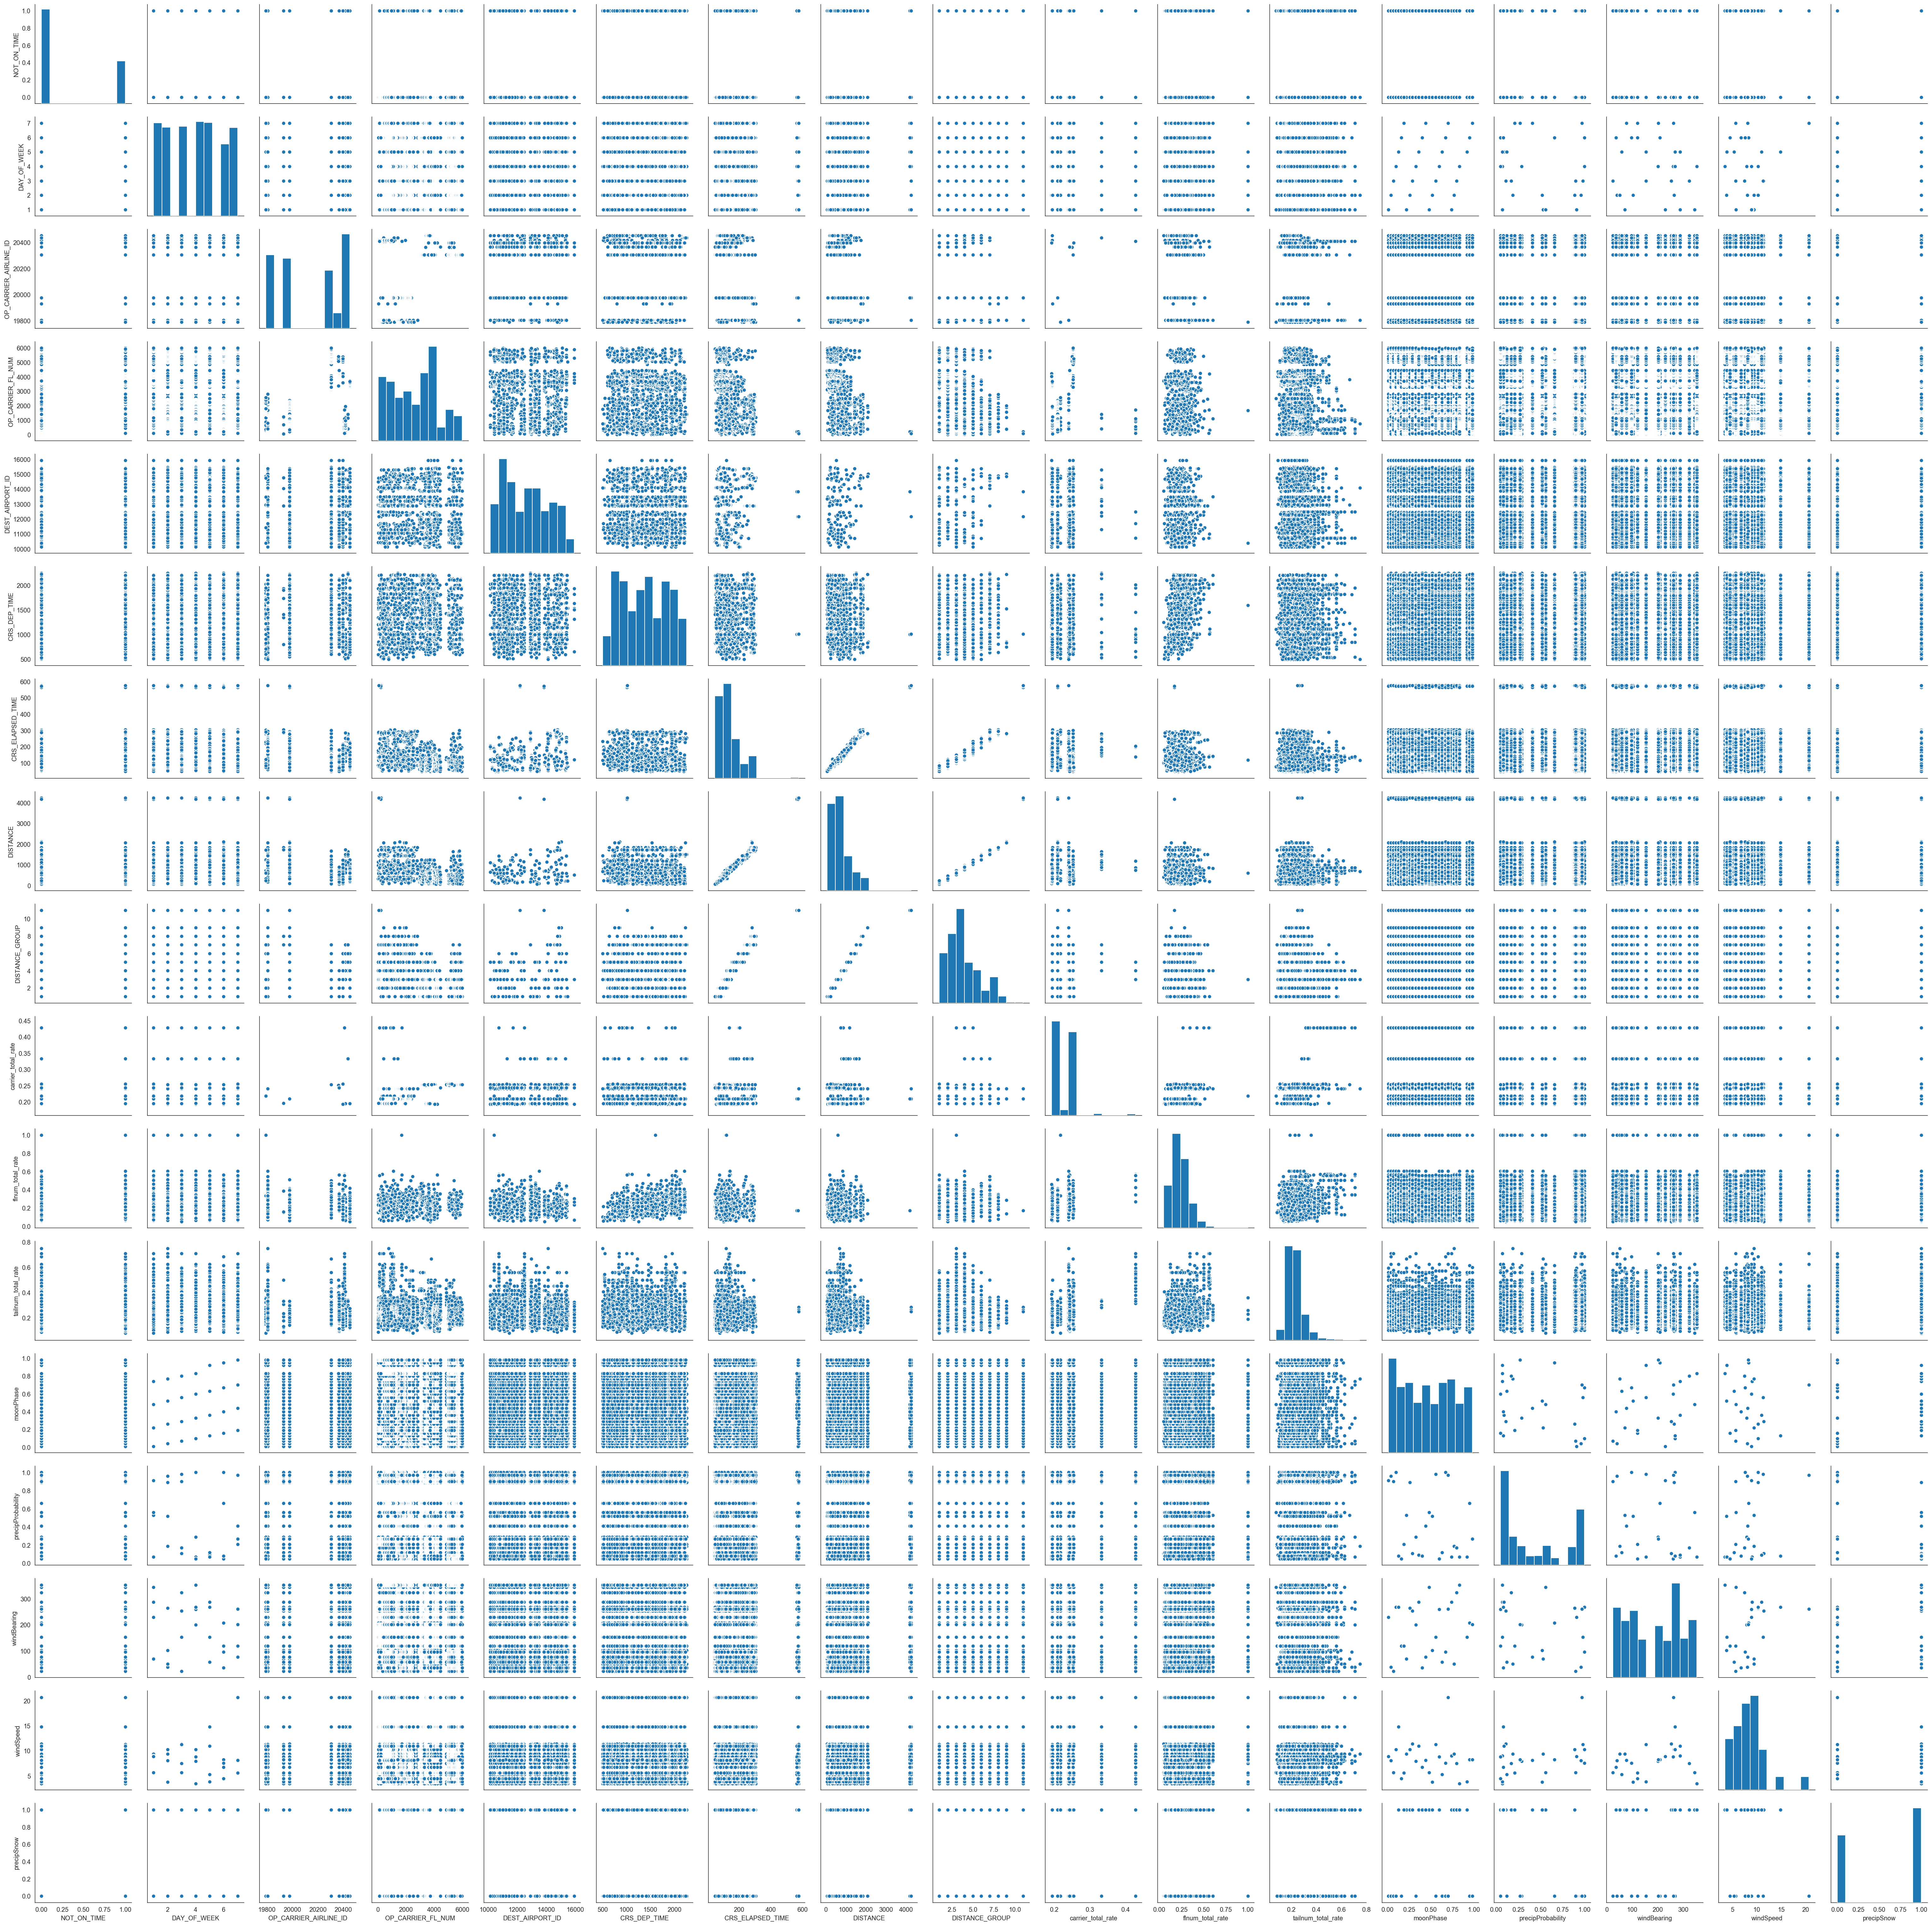

In [36]:
sns.pairplot(flightORD[mask])

In [ ]:
sns.pairplot(flightORD[mask])

# Holdout

In [54]:
Xmask = [
    'DAY_OF_WEEK', 
    'OP_CARRIER_AIRLINE_ID', 
    'OP_CARRIER_FL_NUM', 
    'DEST_AIRPORT_ID',
    'CRS_DEP_TIME', 
    'CRS_ELAPSED_TIME', 
    'DISTANCE',
    'DISTANCE_GROUP',
    'carrier_total_rate', 
    'carrier_cancel_rate', 
    'carrier_delay_rate', 
    'flnum_total_rate', 
    'flnum_cancel_rate',
    'flnum_delay_rate', 
    'tailnum_total_rate', 
    'tailnum_cancel_rate',
    'tailnum_delay_rate', 
    'moonPhase', 
    'precipProbability',
    'precipAccumulation', 
    'precipIntensityMax', 
    'precipType', 
    'windBearing',
    'windSpeed',
    'precipSnow'
]

In [37]:
Xmask = [
    'DAY_OF_WEEK', 
    'OP_CARRIER_AIRLINE_ID', 
    'OP_CARRIER_FL_NUM', 
    'DEST_AIRPORT_ID',
    'CRS_DEP_TIME', 
    'CRS_ELAPSED_TIME', 
    'DISTANCE',
    'DISTANCE_GROUP',
    'carrier_total_rate', 
    'flnum_total_rate', 
    'tailnum_total_rate', 
    'moonPhase', 
    'precipProbability',
    'windBearing',
    'windSpeed',
    'precipSnow'
]

In [45]:
X, y = flightORD[Xmask], flightORD.NOT_ON_TIME

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=1984, stratify=y)

# Trying some Models

In [86]:
models = {
    'Dummy':DummyClassifier(strategy='most_frequent'),
    'KNN': KNeighborsClassifier(n_neighbors=6),
    'Logistic Regression': LogisticRegression(solver='lbfgs', C=1e8),
    'Naive Bayes': GaussianNB(),
    #'Linear SVM': LinearSVC(),
    #'SVM': SVC(gamma='auto', probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

In [47]:
for name, model in models.items():
    y_pred = model.fit(X_train,y_train).predict(X_test)
    
    
    print(f'''
    Model: {name} 
     \taccuracy: {accuracy_score(y_test, y_pred):.4}
     \tprecision:{precision_score(y_test, y_pred):.4} 
     \trecall:   {recall_score(y_test, y_pred):.4}
     \tf1 score: {f1_score(y_test, y_pred):.4}''')

/Users/nkfoster/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nkfoster/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



    Model: Dummy 
     	accuracy: 0.6896
     	precision:0.0 
     	recall:   0.0
     	f1 score: 0.0

    Model: KNN 
     	accuracy: 0.6651
     	precision:0.3881 
     	recall:   0.1367
     	f1 score: 0.2022

    Model: Logistic Regression 
     	accuracy: 0.6894
     	precision:0.4783 
     	recall:   0.007407
     	f1 score: 0.01459

    Model: Naive Bayes 
     	accuracy: 0.6971
     	precision:0.5231 
     	recall:   0.2747
     	f1 score: 0.3603

    Model: Decision Tree 
     	accuracy: 0.6689
     	precision:0.4681 
     	recall:   0.4889
     	f1 score: 0.4783

    Model: Random Forest 
     	accuracy: 0.7508
     	precision:0.6496 
     	recall:   0.4283
     	f1 score: 0.5162


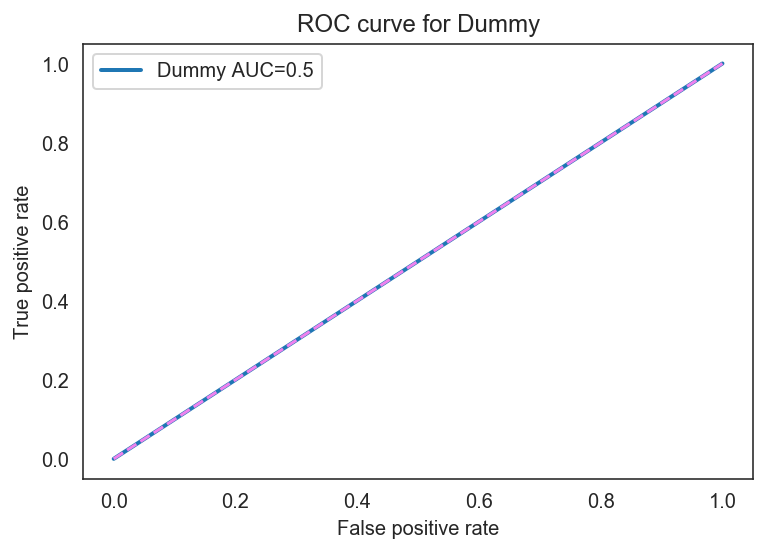

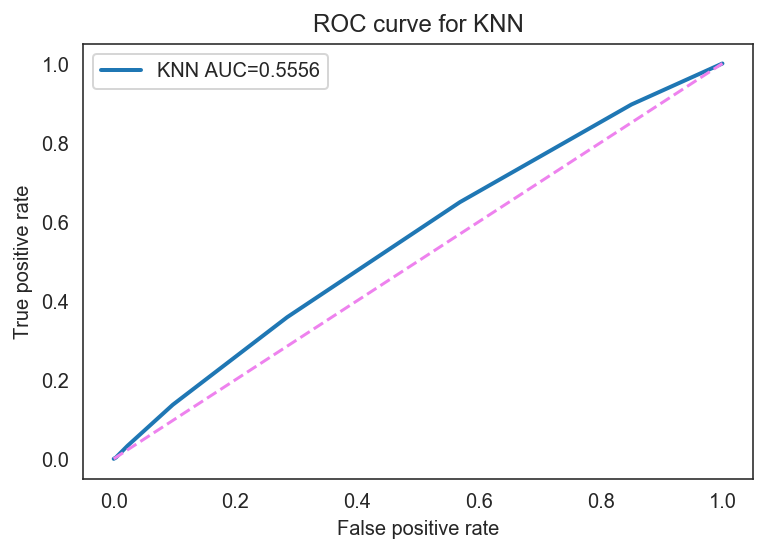

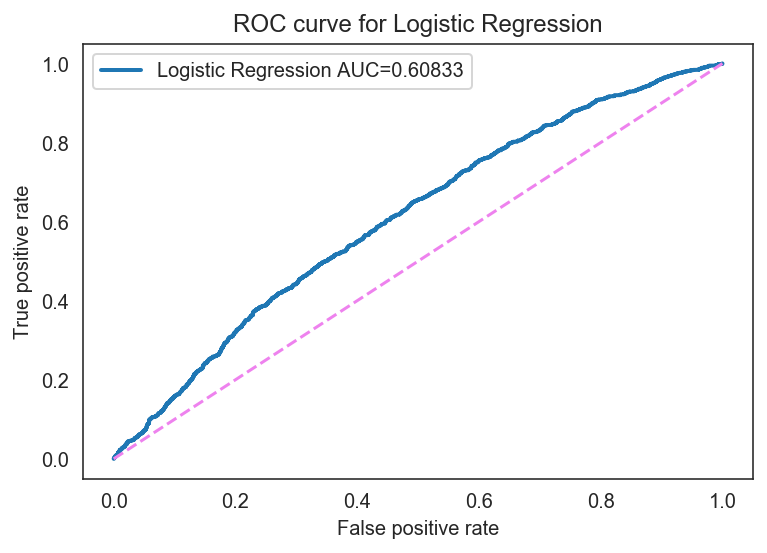

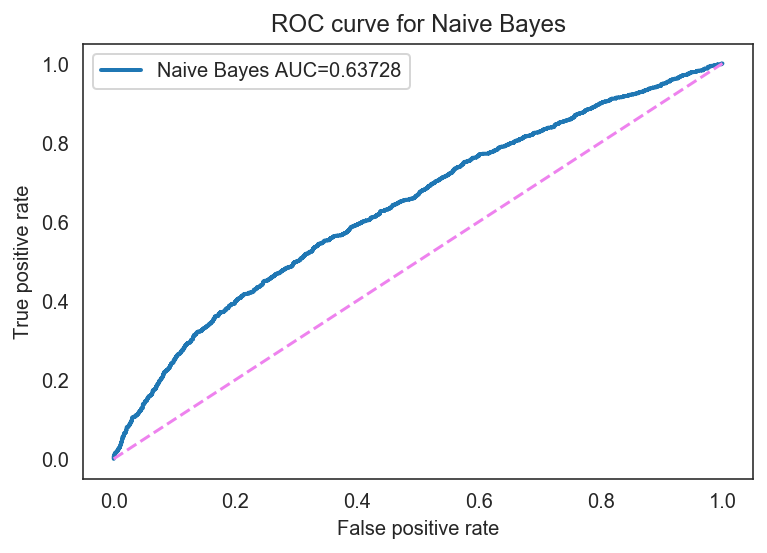

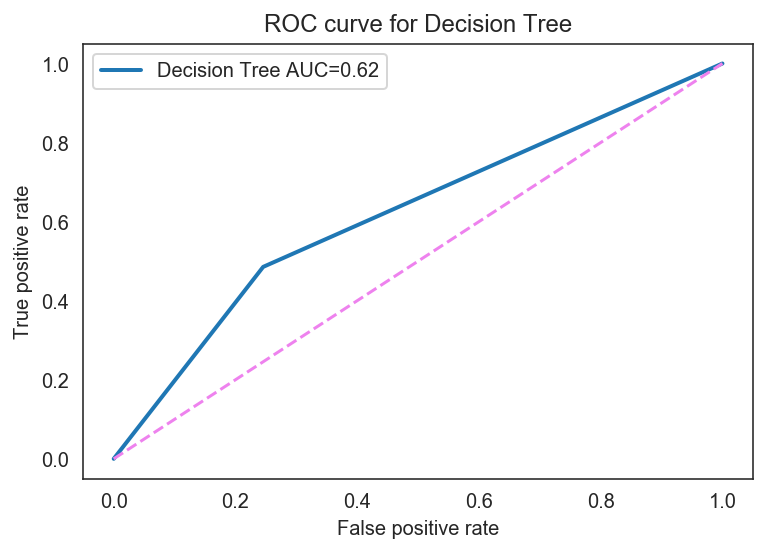

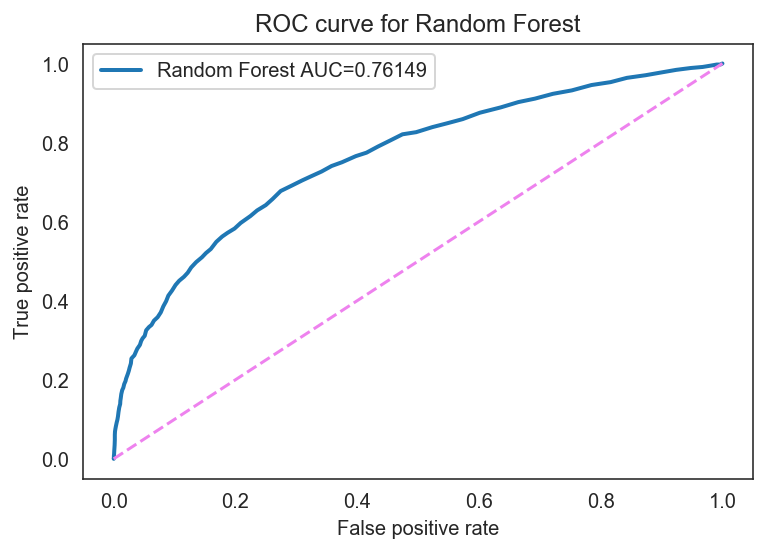

In [48]:
for name, model in models.items():
    fit = model.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_test, fit.predict_proba(X_test)[:,1])

    #plt.figure(figsize=[10,6])
    plt.plot(fpr, tpr,lw=2, label=f'{name} AUC={roc_auc_score(y_test, fit.predict_proba(X_test)[:,1]):.5}')
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])


    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC curve for {name}')
    plt.legend()
    plt.show()

In [50]:
ros = RandomOverSampler(random_state=57)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)

In [80]:
kf = KFold(n_splits=5, shuffle=True, random_state=4444)

metrics = ['accuracy', 'precision', 'recall', 'f1','roc_auc']

for name, model in models.items():
    print(f'Model: {name}')
    for metric in metrics:
        scores = cross_val_score(model, X, y, cv=kf, scoring=metric)
        print(f'\t{metric}: {np.mean(scores):.5} +- {np.std(scores):.5}')

Model: Dummy
	accuracy: 0.68962 +- 0.0017043
	precision: 0.0 +- 0.0
	recall: 0.0 +- 0.0
	f1: 0.0 +- 0.0
	roc_auc: 0.5 +- 0.0
Model: KNN


/Users/nkfoster/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nkfoster/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


	accuracy: 0.66479 +- 0.0036079
	precision: 0.39007 +- 0.0058648
	recall: 0.14196 +- 0.0099553
	f1: 0.20798 +- 0.010747
	roc_auc: 0.56226 +- 0.0040351
Model: Logistic Regression
	accuracy: 0.69012 +- 0.0021287


/Users/nkfoster/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


	precision: 0.40476 +- 0.33129
	recall: 0.003515 +- 0.0032353


/Users/nkfoster/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


	f1: 0.0069619 +- 0.0063978
	roc_auc: 0.59703 +- 0.0079017
Model: Naive Bayes
	accuracy: 0.68761 +- 0.0067816
	precision: 0.49555 +- 0.026086
	recall: 0.26134 +- 0.0090589
	f1: 0.34176 +- 0.0065945
	roc_auc: 0.62901 +- 0.014294
Model: Decision Tree
	accuracy: 0.67553 +- 0.0025944
	precision: 0.47726 +- 0.0050344
	recall: 0.48978 +- 0.0062687
	f1: 0.48606 +- 0.0041714
	roc_auc: 0.62646 +- 0.0049617
Model: Random Forest
	accuracy: 0.75898 +- 0.0042049
	precision: 0.67823 +- 0.015003
	recall: 0.43847 +- 0.0084361
	f1: 0.53278 +- 0.010514
	roc_auc: 0.76117 +- 0.0026682


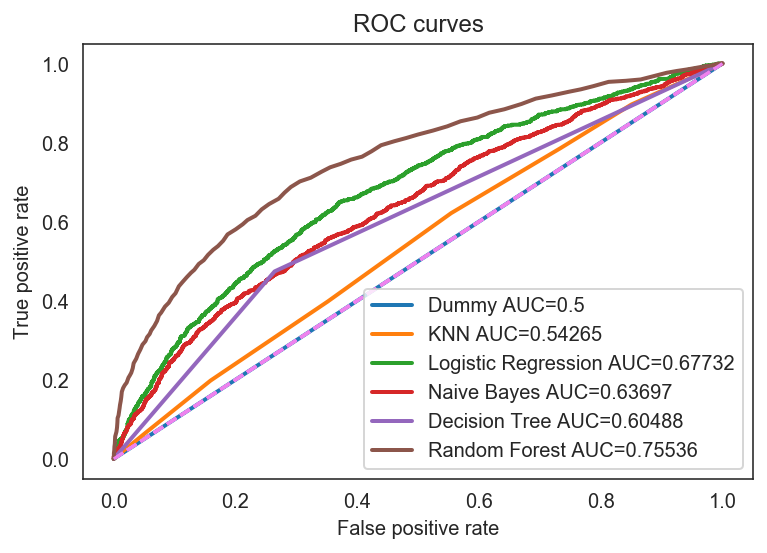

In [52]:
for name, model in models.items():
    fit = model.fit(X_resampled, y_resampled)
    fpr, tpr, thresholds = roc_curve(y_test, fit.predict_proba(X_test)[:,1])

    #plt.figure(figsize=[10,6])
    plt.plot(fpr, tpr,lw=2, label=f'{name} AUC={roc_auc_score(y_test, fit.predict_proba(X_test)[:,1]):.5}')
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])


    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curves')
    #plt.title(f'ROC curve for {name}')
    plt.legend()
    #plt.show()

In [79]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=520)

metrics = ['accuracy', 'precision', 'recall', 'f1','roc_auc']

for name, model in models.items():
    print(f'Model: {name}')
    for metric in metrics:
        scores = cross_val_score(model, X_resampled, y_resampled, cv=kf, scoring=metric)
        print(f'\t{metric}: {np.mean(scores):.5} +- {np.std(scores):.5}')

Model: Dummy
	accuracy: 0.5 +- 0.0
	precision: 0.0 +- 0.0
	recall: 0.0 +- 0.0
	f1: 0.0 +- 0.0
	roc_auc: 0.5 +- 0.0
Model: KNN


/Users/nkfoster/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nkfoster/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


	accuracy: 0.62178 +- 0.0043332
	precision: 0.63375 +- 0.0070083
	recall: 0.57745 +- 0.0047849
	f1: 0.60424 +- 0.0019428
	roc_auc: 0.67144 +- 0.0066023
Model: Logistic Regression
	accuracy: 0.62076 +- 0.004867
	precision: 0.61588 +- 0.0026979
	recall: 0.64163 +- 0.015049
	f1: 0.62843 +- 0.0084262
	roc_auc: 0.66948 +- 0.0058293
Model: Naive Bayes
	accuracy: 0.59298 +- 0.0056241
	precision: 0.58659 +- 0.00538
	recall: 0.63004 +- 0.012115
	f1: 0.60748 +- 0.0068989
	roc_auc: 0.62847 +- 0.0042226
Model: Decision Tree
	accuracy: 0.81388 +- 0.0031047
	precision: 0.77363 +- 0.0036635
	recall: 0.89141 +- 0.0047051
	f1: 0.82891 +- 0.0035876
	roc_auc: 0.81415 +- 0.0035558
Model: Random Forest
	accuracy: 0.87155 +- 0.0032951
	precision: 0.85269 +- 0.0039051
	recall: 0.89997 +- 0.0043468
	f1: 0.87434 +- 0.0033968
	roc_auc: 0.9419 +- 0.0026627


## Investigate some of the parameters

In [53]:
RF = RandomForestClassifier(n_estimators=100).fit(X_resampled,y_resampled)

In [54]:
sorted(list(zip(RF.feature_importances_,X.columns)))

[(0.011032693843693297, 'precipSnow'),
 (0.02735970992456346, 'DISTANCE_GROUP'),
 (0.028751346828827126, 'OP_CARRIER_AIRLINE_ID'),
 (0.031131773667311208, 'carrier_total_rate'),
 (0.03330723158329916, 'DAY_OF_WEEK'),
 (0.0363832225085343, 'windBearing'),
 (0.03808302209880517, 'windSpeed'),
 (0.043920329409314895, 'moonPhase'),
 (0.05739282603741842, 'precipProbability'),
 (0.08012922886339365, 'DEST_AIRPORT_ID'),
 (0.08022903786877626, 'flnum_total_rate'),
 (0.08050895932216237, 'DISTANCE'),
 (0.0876141566919838, 'tailnum_total_rate'),
 (0.09872778826568142, 'CRS_ELAPSED_TIME'),
 (0.1141838540864596, 'OP_CARRIER_FL_NUM'),
 (0.15124481899977582, 'CRS_DEP_TIME')]

In [56]:
y_pred = RF.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[2814,  485],
       [ 712,  773]])

In [57]:
accuracy_score(y_test,RF.predict(X_test))

0.7497909698996655

In [58]:
roc_auc_score(y_test,RF.predict(X_test))

0.6867622368986418

In [59]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.85      0.82      3299
         1.0       0.61      0.52      0.56      1485

    accuracy                           0.75      4784
   macro avg       0.71      0.69      0.69      4784
weighted avg       0.74      0.75      0.74      4784



In [60]:
scaler = StandardScaler()
X_RS = scaler.fit_transform(X_resampled)
X_te_S =scaler.transform(X_test)
LM = LogisticRegression(solver='lbfgs', C=1e8).fit(X_RS,y_resampled)

In [61]:
sorted(list(zip(LM.coef_[0],X.columns)))


[(-0.13589550557132438, 'DISTANCE_GROUP'),
 (-0.08381054520495475, 'windBearing'),
 (-0.07610490867776051, 'CRS_ELAPSED_TIME'),
 (-0.006102364027539608, 'DEST_AIRPORT_ID'),
 (0.023028089154609476, 'windSpeed'),
 (0.024659272756472377, 'flnum_total_rate'),
 (0.06285265988172405, 'tailnum_total_rate'),
 (0.06375987704960019, 'OP_CARRIER_AIRLINE_ID'),
 (0.09085409819096503, 'carrier_total_rate'),
 (0.0967594811001974, 'moonPhase'),
 (0.11629837689167667, 'OP_CARRIER_FL_NUM'),
 (0.13914951344115448, 'DAY_OF_WEEK'),
 (0.19639396762985784, 'DISTANCE'),
 (0.2657786444325898, 'CRS_DEP_TIME'),
 (0.5926637774062671, 'precipSnow'),
 (0.6649945498424753, 'precipProbability')]

In [62]:
accuracy_score(y_test,LM.predict(X_te_S))

0.6275083612040134

In [63]:
confusion_matrix(y_test,LM.predict(X_te_S))

array([[2028, 1271],
       [ 511,  974]])

In [69]:
par = {'max_depth':[1,2,3,4,5,6,7,8,9,10],'min_samples_leaf':[1,2,3]}

In [70]:
gsrf = GridSearchCV(RandomForestClassifier(n_estimators=100),par,cv=kf)

In [71]:
gsrf.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=4444, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                      

In [67]:
gsrf.best_params_

{'max_depth': 6, 'min_samples_leaf': 1}

In [68]:
gsrf.best_score_

0.7467467990593154

# Oversample CV

In [87]:
metrics = {
    'accuracy':accuracy_score, 
    'precision':precision_score, 
    'recall':recall_score, 
    'f1':f1_score,
    'roc_auc':roc_auc_score
}

In [88]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=520)

def cv_w_ros(model,X_train, y_train, metrics, kf):
    scores = []

    for tr, val in kf.split(X_train, y_train):

        X_tr, y_tr = X_train.iloc[tr], y_train.iloc[tr]
        X_val, y_val = X_train.iloc[val], y_train.iloc[val]

        #Oversample
        ros = RandomOverSampler(random_state=57)
        X_R_tr, y_R_tr = ros.fit_sample(X_tr, y_tr)
        
        #Scale
        scaler = StandardScaler()
        X_RS_tr = scaler.fit_transform(X_R_tr)
        X_S_val =scaler.transform(X_val)
        
        fit = model.fit(X_RS_tr, y_R_tr)
        y_pred = fit.predict(X_S_val)

        score = dict()

        for name, metric in metrics.items():
            score[name] = metric(y_val, y_pred)

        scores.append(score)

    return pd.DataFrame(scores)

In [93]:
for name, model in models.items():
    score = cv_w_ros(model, X_train, y_train, metrics, kf)
    print(name)
    print(score.describe(),'\n')

/Users/nkfoster/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nkfoster/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nkfoster/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nkfoster/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

Dummy
       accuracy  precision  recall   f1  roc_auc
count  5.000000        5.0     5.0  5.0      5.0
mean   0.689626        0.0     0.0  0.0      0.5
std    0.000080        0.0     0.0  0.0      0.0
min    0.689574        0.0     0.0  0.0      0.5
25%    0.689574        0.0     0.0  0.0      0.5
50%    0.689574        0.0     0.0  0.0      0.5
75%    0.689655        0.0     0.0  0.0      0.5
max    0.689754        0.0     0.0  0.0      0.5 

KNN
       accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.675569   0.480067  0.546055  0.510901  0.639957
std    0.004664   0.006526  0.014297  0.009235  0.006652
min    0.671108   0.473993  0.531987  0.503987  0.635641
25%    0.673896   0.478130  0.533670  0.504375  0.635725
50%    0.674419   0.478198  0.544613  0.506855  0.636322
75%    0.674941   0.478788  0.553872  0.513261  0.640900
max    0.683481   0.491228  0.566133  0.526027  0.651198 

Logistic Regression
       accur

In [76]:
score1 = cv_w_ros(RandomForestClassifier(n_estimators=100), X_train, y_train, metrics, kf)
score1.describe()

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.749046   0.617584  0.502779  0.554288  0.681331
std    0.001341   0.002471  0.005205  0.003533  0.002184
min    0.747583   0.613730  0.495791  0.549697  0.678577
25%    0.747910   0.616754  0.500000  0.553330  0.680676
50%    0.749412   0.618163  0.504209  0.553604  0.680845
75%    0.749412   0.619395  0.504209  0.555401  0.682002
max    0.750915   0.619877  0.509688  0.559408  0.684552

In [77]:
score2 = cv_w_ros(RandomForestClassifier(n_estimators=10), X_train, y_train, metrics, kf)
score2.describe()

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.736661   0.597953  0.462875  0.521758  0.661378
std    0.005919   0.012982  0.011907  0.010989  0.006920
min    0.729814   0.582796  0.446970  0.509842  0.654545
25%    0.733281   0.593296  0.456229  0.511804  0.654602
50%    0.735041   0.593348  0.465488  0.521698  0.660937
75%    0.740460   0.602972  0.467172  0.531864  0.668398
max    0.744709   0.617353  0.478517  0.533584  0.668410

In [78]:
score1_lm = cv_w_ros(LogisticRegression(solver='lbfgs', C=1e8), X_train, y_train, metrics, kf)
score1_lm.describe()

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.614320   0.420077  0.637484  0.506431  0.620690
std    0.010806   0.011347  0.016443  0.013366  0.012274
min    0.601358   0.406007  0.614478  0.488948  0.604966
25%    0.608048   0.414097  0.632997  0.500666  0.614907
50%    0.611706   0.417314  0.632997  0.503010  0.617559
75%    0.622582   0.428888  0.652906  0.517702  0.630925
max    0.627907   0.434078  0.654040  0.521827  0.635091

# Tweak features

In [654]:
metrics = {
    'accuracy':accuracy_score, 
    'precision':precision_score, 
    'recall':recall_score, 
    'f1':f1_score,
    'roc_auc':roc_auc_score
}

## RF

### Mask 3

In [671]:
Xmask3 = [
    'DAY_OF_WEEK', 
    #'OP_CARRIER_AIRLINE_ID', 
    'OP_CARRIER_FL_NUM', 
    'DEST_AIRPORT_ID',
    'CRS_DEP_TIME', 
    'CRS_ELAPSED_TIME', 
    'DISTANCE',
    #'carrier_total_rate', 
    #'carrier_cancel_rate', 
    #'carrier_delay_rate', 
    'flnum_total_rate', 
    'flnum_cancel_rate',
    'flnum_delay_rate', 
    'tailnum_total_rate', 
    'tailnum_cancel_rate',
    'tailnum_delay_rate', 
    #'moonPhase', 
    'precipProbability',
    'precipAccumulation', 
    #'precipIntensityMax', 
    #'precipType', 
    'windBearing',
    'windSpeed',
    'precipSnow'
]

In [692]:
score3 = cv_w_ros(RandomForestClassifier(n_estimators=100, random_state=914), X_train[Xmask3], y_train, metrics, kf)
score3.describe()

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.747897   0.619210  0.487961  0.545787  0.676422
std    0.005929   0.013170  0.006639  0.008829  0.005924
min    0.737915   0.597062  0.478956  0.531527  0.666723
25%    0.749085   0.620507  0.485690  0.545885  0.676737
50%    0.749151   0.622438  0.486099  0.546143  0.676936
75%    0.749478   0.623784  0.494108  0.550141  0.679036
max    0.753854   0.632258  0.494949  0.555241  0.682677

### Mask 4

In [673]:
Xmask4 = [
    'DAY_OF_WEEK', 
    #'OP_CARRIER_AIRLINE_ID', 
    'OP_CARRIER_FL_NUM', 
    'DEST_AIRPORT_ID',
    'CRS_DEP_TIME', 
    'CRS_ELAPSED_TIME', 
    #'DISTANCE',
    'DISTANCE_GROUP',
    'carrier_total_rate', 
    #'carrier_cancel_rate', 
    #'carrier_delay_rate', 
    'flnum_total_rate', 
    #'flnum_cancel_rate',
    #'flnum_delay_rate', 
    'tailnum_total_rate', 
    #'tailnum_cancel_rate',
    #'tailnum_delay_rate', 
    #'moonPhase', 
    'precipProbability',
    'precipAccumulation', 
    #'precipIntensityMax', 
    #'precipType', 
    'windBearing',
    #'windSpeed',
    'precipSnow'
]

In [675]:
score4 = cv_w_ros(RandomForestClassifier(n_estimators=100, random_state=914), X_train[Xmask4], y_train, metrics, kf)
score4.describe()

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.748890   0.618050  0.500085  0.552801  0.680476
std    0.004759   0.010043  0.009819  0.008452  0.005479
min    0.742096   0.602030  0.488215  0.544345  0.675309
25%    0.746276   0.615058  0.494108  0.545789  0.675332
50%    0.749739   0.621822  0.499158  0.550657  0.679440
75%    0.752809   0.623722  0.505476  0.559963  0.685288
max    0.753528   0.627615  0.513468  0.563250  0.687011

### Mask 5

In [676]:
Xmask5 = [
    'DAY_OF_WEEK', 
    #'OP_CARRIER_AIRLINE_ID', 
    #'OP_CARRIER_FL_NUM', 
    #'DEST_AIRPORT_ID',
    'CRS_DEP_TIME', 
    #'CRS_ELAPSED_TIME', 
    #'DISTANCE',
    'DISTANCE_GROUP',
    'carrier_total_rate', 
    #'carrier_cancel_rate', 
    #'carrier_delay_rate', 
    'flnum_total_rate', 
    #'flnum_cancel_rate',
    #'flnum_delay_rate', 
    'tailnum_total_rate', 
    #'tailnum_cancel_rate',
    #'tailnum_delay_rate', 
    #'moonPhase', 
    'precipProbability',
    'precipAccumulation', 
    #'precipIntensityMax', 
    #'precipType', 
    'windBearing',
    #'windSpeed',
    'precipSnow'
]

In [677]:
score5 = cv_w_ros(RandomForestClassifier(n_estimators=100, random_state=914), X_train[Xmask5], y_train, metrics, kf)
score5.describe()

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.737393   0.590349  0.503116  0.543228  0.672974
std    0.003922   0.008179  0.006056  0.005668  0.003877
min    0.732759   0.580645  0.495791  0.537313  0.668750
25%    0.735563   0.585603  0.500000  0.541360  0.671835
50%    0.736347   0.588351  0.501684  0.541572  0.672299
75%    0.739221   0.596154  0.506734  0.543321  0.672655
max    0.743074   0.600990  0.511373  0.552572  0.679332

In [687]:
cv_w_ros(GaussianNB(), X_train[Xmask5], y_train, metrics, kf).describe()

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.701124   0.525725  0.383399  0.443223  0.613760
std    0.005590   0.012668  0.013618  0.009206  0.004968
min    0.692529   0.505920  0.362795  0.429711  0.608074
25%    0.701071   0.525822  0.377104  0.439216  0.610880
50%    0.701071   0.526895  0.387532  0.444025  0.612008
75%    0.702900   0.528814  0.393939  0.451520  0.617962
max    0.708050   0.541176  0.395623  0.451645  0.619874

In [688]:
cv_w_ros(DecisionTreeClassifier(), X_train[Xmask5], y_train, metrics, kf).describe()

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.676509   0.478672  0.473315  0.475917  0.620637
std    0.004165   0.006674  0.011870  0.007468  0.004806
min    0.671806   0.470588  0.457912  0.464164  0.613003
25%    0.674072   0.475530  0.470539  0.473328  0.618748
50%    0.674941   0.476150  0.473064  0.479149  0.623463
75%    0.680167   0.484509  0.473906  0.479727  0.623751
max    0.681557   0.486580  0.491154  0.483216  0.624221

In [679]:
DT5 = DecisionTreeClassifier().fit(X_train[Xmask5], y_train)

In [684]:
import graphviz 

In [686]:
dot_data = tree.export_graphviz(DT5, out_file=None,max_depth=6) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

'iris.pdf'

### Mask 6

In [26]:
Xmask6 = [
    'DAY_OF_WEEK', 
    #'OP_CARRIER_AIRLINE_ID', 
    'OP_CARRIER_FL_NUM', 
    'DEST_AIRPORT_ID',
    'CRS_DEP_TIME', 
    'CRS_ELAPSED_TIME', 
    #'DISTANCE',
    'DISTANCE_GROUP',
    'carrier_total_rate', 
    #'carrier_cancel_rate', 
    #'carrier_delay_rate', 
    'flnum_total_rate', 
    #'flnum_cancel_rate',
    #'flnum_delay_rate', 
    'tailnum_total_rate', 
    #'tailnum_cancel_rate',
    #'tailnum_delay_rate', 
    #'moonPhase', 
    'precipProbability',
    #'precipAccumulation', 
    #'precipIntensityMax', 
    #'precipType', 
    'windBearing',
    #'windSpeed',
    'precipSnow'
]

In [713]:
score6 = cv_w_ros(RandomForestClassifier(n_estimators=100, random_state=914), X_train[Xmask6], y_train, metrics, kf)
score6.describe()

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.750144   0.621996  0.497224  0.552595  0.680599
std    0.002402   0.005344  0.010240  0.006424  0.003860
min    0.747844   0.614359  0.484007  0.546059  0.676889
25%    0.748106   0.619403  0.489057  0.546566  0.677041
50%    0.750261   0.622385  0.500842  0.553860  0.680865
75%    0.750719   0.626362  0.504209  0.555037  0.682024
max    0.753790   0.627471  0.508003  0.561453  0.686173

In [709]:
score6 = cv_w_ros(RandomForestClassifier(n_estimators=100, random_state=914), X_train[Xmask6], y_train, metrics, kf)
score6.describe()

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.750144   0.621996  0.497224  0.552595  0.680599
std    0.002402   0.005344  0.010240  0.006424  0.003860
min    0.747844   0.614359  0.484007  0.546059  0.676889
25%    0.748106   0.619403  0.489057  0.546566  0.677041
50%    0.750261   0.622385  0.500842  0.553860  0.680865
75%    0.750719   0.626362  0.504209  0.555037  0.682024
max    0.753790   0.627471  0.508003  0.561453  0.686173

In [695]:
cv_w_ros(GaussianNB(), X_train[Xmask6], y_train, metrics, kf).describe()

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.593676   0.401134  0.626036  0.488767  0.602576
std    0.009123   0.005777  0.023699  0.006608  0.004771
min    0.580240   0.393924  0.596801  0.477280  0.594915
25%    0.592215   0.397644  0.607744  0.488994  0.600926
50%    0.594199   0.401375  0.631313  0.492094  0.605051
75%    0.596028   0.403660  0.638889  0.492449  0.605729
max    0.605696   0.409065  0.655434  0.493017  0.606259

# Final train

In [27]:
ros = RandomOverSampler(random_state=57)
X_resampled, y_resampled = ros.fit_sample(X_train[Xmask6], y_train)

In [28]:
RFfit = RandomForestClassifier(n_estimators=100, random_state=914).fit(X_resampled, y_resampled)

In [29]:
y_pred = RFfit.predict(X_test[Xmask6])

In [30]:
print(f'''
\taccuracy: {accuracy_score(y_test, y_pred):.4}
\tprecision:{precision_score(y_test, y_pred):.4} 
\trecall:   {recall_score(y_test, y_pred):.4}
\tf1 score: {f1_score(y_test, y_pred):.4}
\troc auc:  {roc_auc_score(y_test, y_pred):.4}''')


	accuracy: 0.7444
	precision:0.6069 
	recall:   0.501
	f1 score: 0.5489
	roc auc:  0.6775


In [744]:
pickle.dump(RFfit, open('my_pickled_model.p','wb'))

In [31]:
sorted(list(zip(RFfit.feature_importances_,X[Xmask6].columns)))

[(0.01627215778048431, 'precipSnow'),
 (0.038965581596100494, 'DISTANCE_GROUP'),
 (0.04144848616614602, 'carrier_total_rate'),
 (0.05534731853611772, 'DAY_OF_WEEK'),
 (0.0708052414269836, 'windBearing'),
 (0.08827572833550051, 'flnum_total_rate'),
 (0.09078752733599549, 'precipProbability'),
 (0.09526646596323075, 'DEST_AIRPORT_ID'),
 (0.10004982988185991, 'tailnum_total_rate'),
 (0.11571035560301685, 'CRS_ELAPSED_TIME'),
 (0.1280008762350888, 'OP_CARRIER_FL_NUM'),
 (0.15907043113947547, 'CRS_DEP_TIME')]

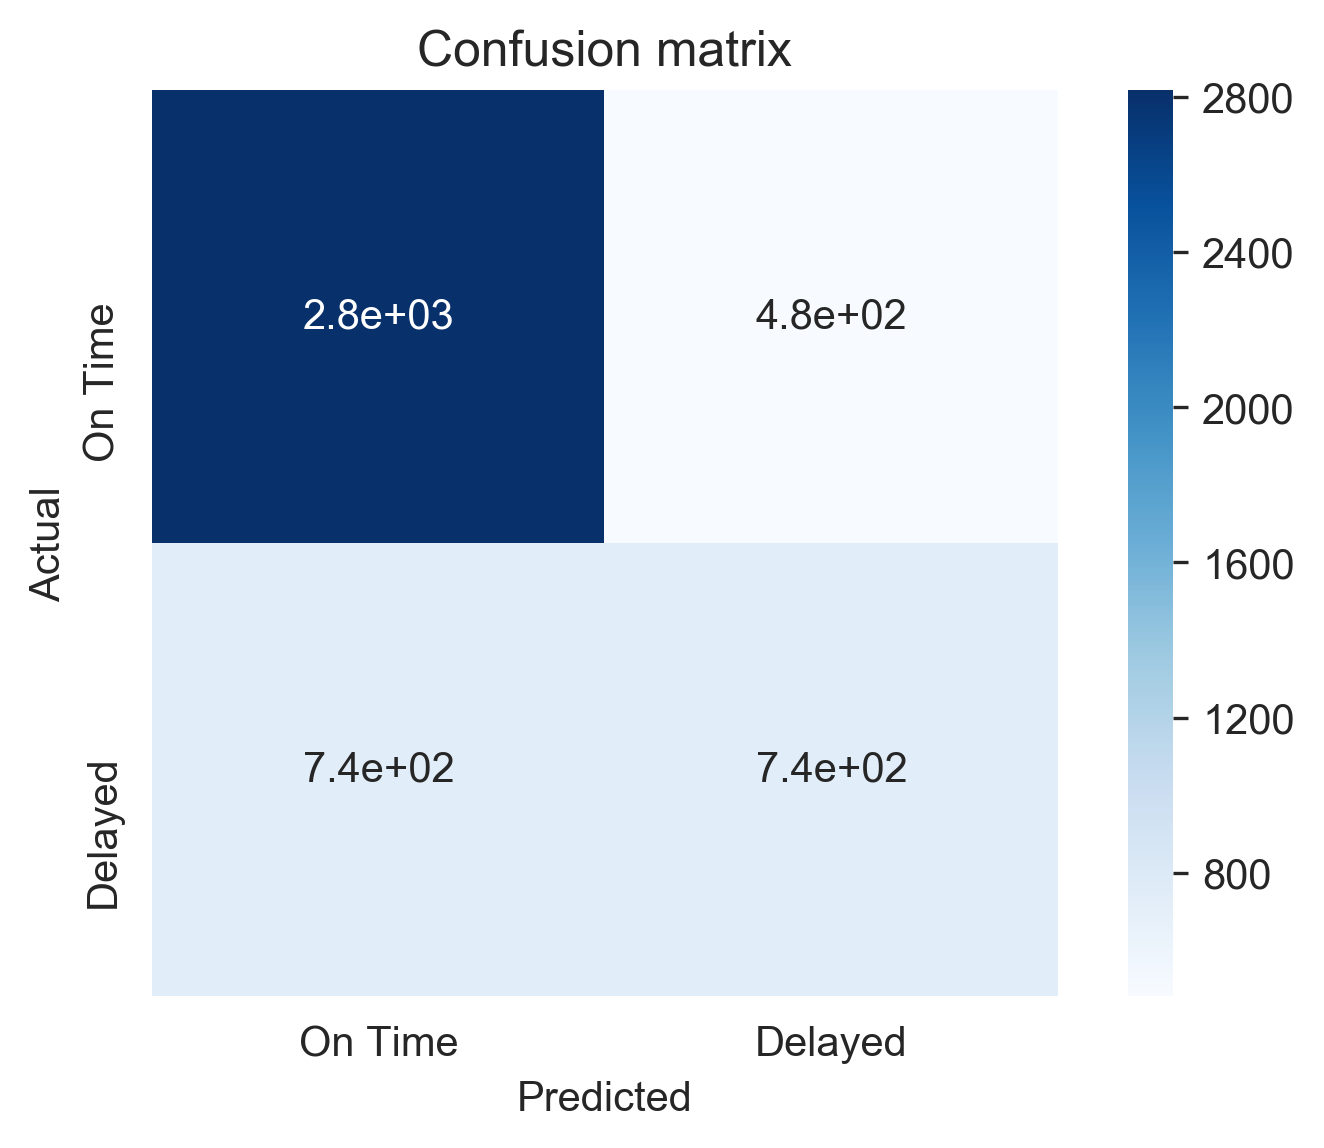

In [39]:
plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, annot=True, square=True, xticklabels=['On Time', 'Delayed'], yticklabels=['On Time', 'Delayed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.savefig('confusion matrix.png');

## Logistic

In [587]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=520)

scores = []

for tr, val in kf.split(X_train, y_train):
    
    X_tr, y_tr = X_train.iloc[tr], y_train.iloc[tr]
    X_val, y_val = X_train.iloc[val], y_train.iloc[val]
    
    ros = RandomOverSampler(random_state=57)
    X_resampled, y_resampled = ros.fit_sample(X_tr, y_tr)
    
    scaler = StandardScaler()
    X_R_S = scaler.fit_transform(X_resampled)
    X_val_S =scaler.transform(X_val)
    LM = LogisticRegression().fit(X_R_S, y_resampled)
    
    y_pred = RF.predict(X_val_S)
    
    score = dict()
    
    for name, metric in metrics.items():
        score[name] = metric(y_val, y_pred)
    
    scores.append(score)

pd.DataFrame(scores).describe()

/Users/nkfoster/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nkfoster/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nkfoster/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nkfoster/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nkfoster/opt/anaconda3/envs/metis/lib/python3.7/site-packages/skl

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.681997   0.360602  0.031992  0.058762  0.503265
std    0.002759   0.051895  0.005256  0.009534  0.003371
min    0.678338   0.287129  0.024411  0.044996  0.498564
25%    0.679990   0.333333  0.031145  0.056967  0.501557
50%    0.683220   0.373737  0.031171  0.057543  0.503839
75%    0.683303   0.386792  0.034512  0.063369  0.504941
max    0.685132   0.422018  0.038721  0.070933  0.507424

# Cancellations

In [715]:
Xmask = [
    'DAY_OF_WEEK', 
    'OP_CARRIER_AIRLINE_ID', 
    'OP_CARRIER_FL_NUM', 
    'DEST_AIRPORT_ID',
    'CRS_DEP_TIME', 
    'CRS_ELAPSED_TIME', 
    'DISTANCE',
    'DISTANCE_GROUP',
    'carrier_total_rate', 
    'carrier_cancel_rate', 
    'carrier_delay_rate', 
    'flnum_total_rate', 
    'flnum_cancel_rate',
    'flnum_delay_rate', 
    'tailnum_total_rate', 
    'tailnum_cancel_rate',
    'tailnum_delay_rate', 
    'moonPhase', 
    'precipProbability',
    'precipAccumulation', 
    'precipIntensityMax', 
    'precipType', 
    'windBearing',
    'windSpeed',
    'precipSnow'
]

In [716]:
cX, cy = flightORD[Xmask], flightORD.CANCELLED

In [717]:
cX_train, cX_test, cy_train, cy_test = train_test_split(cX, cy, test_size=.20, random_state=1984, stratify=y)

In [722]:
can_score = cv_w_ros(RandomForestClassifier(n_estimators=100, random_state=914), cX_train[Xmask], cy_train, metrics, kf)
can_score.describe()

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.954325   0.555922  0.283243  0.375112  0.635828
std    0.003077   0.065035  0.023747  0.034877  0.012802
min    0.949830   0.464646  0.248649  0.323944  0.617048
25%    0.954011   0.548387  0.275676  0.366906  0.632072
50%    0.954272   0.553191  0.281081  0.372760  0.634774
75%    0.955056   0.565657  0.302703  0.394366  0.645448
max    0.958453   0.647727  0.308108  0.417582  0.649798

In [724]:
can_score = cv_w_ros(GaussianNB(), cX_train[Xmask], cy_train, metrics, kf)
can_score.describe()

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.606323   0.094402  0.830270  0.169519  0.712609
std    0.013938   0.005701  0.036381  0.009878  0.022463
min    0.587928   0.084726  0.767568  0.152606  0.673185
25%    0.600470   0.094692  0.832432  0.170374  0.718248
50%    0.603867   0.096422  0.843243  0.172937  0.718256
75%    0.615103   0.096491  0.848649  0.173391  0.725172
max    0.624249   0.099681  0.859459  0.178286  0.728184

In [725]:
can_score = cv_w_ros(GaussianNB(), cX_train[Xmask2], cy_train, metrics, kf)
can_score.describe()

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.625973   0.098492  0.823784  0.175921  0.719855
std    0.020976   0.008242  0.046593  0.014091  0.029846
min    0.593677   0.085351  0.762162  0.153511  0.673640
25%    0.623726   0.098014  0.800000  0.175044  0.713564
50%    0.626078   0.098274  0.827027  0.175258  0.720213
75%    0.635485   0.104193  0.843243  0.186470  0.742187
max    0.650901   0.106630  0.886486  0.189320  0.749668

In [726]:
can_score = cv_w_ros(GaussianNB(), cX_train[Xmask3], cy_train, metrics, kf)
can_score.describe()

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.625973   0.098492  0.823784  0.175921  0.719855
std    0.020976   0.008242  0.046593  0.014091  0.029846
min    0.593677   0.085351  0.762162  0.153511  0.673640
25%    0.623726   0.098014  0.800000  0.175044  0.713564
50%    0.626078   0.098274  0.827027  0.175258  0.720213
75%    0.635485   0.104193  0.843243  0.186470  0.742187
max    0.650901   0.106630  0.886486  0.189320  0.749668

In [727]:
can_score = cv_w_ros(GaussianNB(), cX_train[Xmask4], cy_train, metrics, kf)
can_score.describe()

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.641495   0.102839  0.827027  0.182889  0.729549
std    0.024383   0.008529  0.033540  0.014237  0.026219
min    0.600732   0.088794  0.783784  0.159516  0.687609
25%    0.643324   0.103169  0.805405  0.183453  0.726289
50%    0.644108   0.103905  0.827027  0.184064  0.730922
75%    0.654821   0.106667  0.854054  0.189911  0.748468
max    0.664489   0.111661  0.864865  0.197500  0.754457

In [728]:
can_score = cv_w_ros(GaussianNB(), cX_train[Xmask5], cy_train, metrics, kf)
can_score.describe()

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.745493   0.134095  0.780541  0.228844  0.762126
std    0.009928   0.005260  0.018957  0.008132  0.010659
min    0.728769   0.126205  0.762162  0.217195  0.752314
25%    0.744709   0.131970  0.767568  0.225218  0.755558
50%    0.749673   0.135838  0.778378  0.230581  0.757934
75%    0.750196   0.136406  0.783784  0.232372  0.765862
max    0.754115   0.140056  0.810811  0.238854  0.778964

In [729]:
can_score = cv_w_ros(GaussianNB(), cX_train[Xmask6], cy_train, metrics, kf)
can_score.describe()

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.577162   0.088759  0.834595  0.160440  0.699340
std    0.017660   0.005926  0.039832  0.010333  0.024995
min    0.552914   0.079383  0.778378  0.144072  0.659920
25%    0.568330   0.087690  0.810811  0.158859  0.697003
50%    0.576169   0.089928  0.843243  0.161900  0.698804
75%    0.594199   0.091529  0.870270  0.165638  0.715750
max    0.594199   0.095266  0.870270  0.171733  0.725223

In [730]:
cXmask = [
    #'DAY_OF_WEEK', 
    #'OP_CARRIER_AIRLINE_ID', 
    #'OP_CARRIER_FL_NUM', 
    #'DEST_AIRPORT_ID',
    'CRS_DEP_TIME', 
    #'CRS_ELAPSED_TIME', 
    #'DISTANCE',
    #'DISTANCE_GROUP',
    #'carrier_total_rate', 
    #'carrier_cancel_rate', 
    #'carrier_delay_rate', 
    #'flnum_total_rate', 
    #'flnum_cancel_rate',
    #'flnum_delay_rate', 
    #'tailnum_total_rate', 
    #'tailnum_cancel_rate',
    #'tailnum_delay_rate', 
    #'moonPhase', 
    'precipProbability',
    #'precipAccumulation', 
    #'precipIntensityMax', 
    #'precipType', 
    'windBearing',
    #'windSpeed',
    'precipSnow'
]

In [731]:
can_score = cv_w_ros(GaussianNB(), cX_train[cXmask], cy_train, metrics, kf)
can_score.describe()

accuracy  precision    recall        f1   roc_auc
count  5.000000   5.000000  5.000000  5.000000  5.000000
mean   0.610975   0.087639  0.749189  0.156919  0.676572
std    0.002859   0.002754  0.033452  0.005142  0.014751
min    0.608309   0.085678  0.724324  0.153230  0.665841
25%    0.608571   0.086063  0.724324  0.153846  0.666802
50%    0.610138   0.086654  0.740541  0.155153  0.672028
75%    0.613013   0.087366  0.751351  0.156532  0.676335
max    0.614842   0.092432  0.805405  0.165832  0.701852